<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/%5Bkareem_202200402%5D_XAI_loan_prediction_Gaussian_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
!pip install pyartemis
# Install required libraries
!pip install kagglehub pandas numpy scikit-learn seaborn matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# PDP & ICE
from sklearn.inspection import PartialDependenceDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


#import data csv

In [ ]:
import pandas as pd
df = pd.read_csv("Final DataFrame.csv")

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Initialize the scaler
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [ ]:
X_exp = X.sample(n=100, random_state=8)
X_exp_scaled = scaler.transform(X_exp)
X_exp_scaled_df = pd.DataFrame(X_exp_scaled, columns=X.columns)

# Gaussian Naive Bayes – XAI Techniques

| Technique                        | Type              | Why It Works Well |
|----------------------------------|-------------------|--------------------|
| SHAP (KernelExplainer)          | Local             | Model-agnostic explainer suitable for non-tree models like GNB. |
| Permutation Feature Importance  | Global            | Quantifies global feature relevance despite GNB simplicity. |
| Surrogate Tree                  | Global            | Converts probabilistic GNB output into transparent rules. |
| Partial Dependence Plot (PDP)   | Global            | GNB assumes feature independence, so PDP is well-aligned. |
| ICE (Individual Conditional Expectation) | Local          | Offers individual feature influence visualization. |
| Feature Importance (Z-Scores)   | Global (manual)   | Uses standardized distance from class means, directly tied to GNB’s assumptions. |

#Gaussian Naive Bayes (GNB)

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)


In [ ]:
# performance
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)

print("gnb:", accuracy_gnb * 100 ,"%")


gnb: 82.67 %


###model eval

In [ ]:
classification_rep = classification_report(y_test, y_pred_gnb )
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      8023
           1       0.90      0.14      0.24      1977

    accuracy                           0.83     10000
   macro avg       0.86      0.57      0.57     10000
weighted avg       0.84      0.83      0.77     10000



### Confusion matrix (GNB)

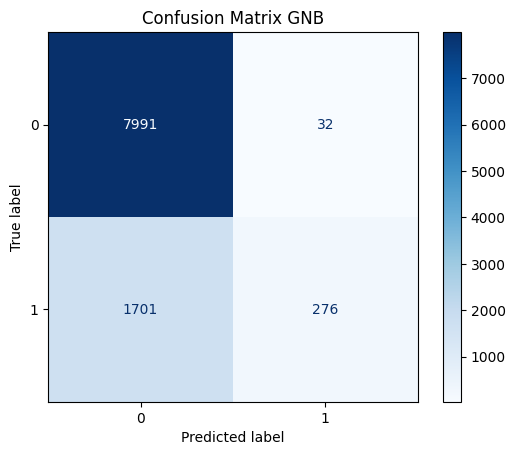

In [ ]:
cm_GNB = confusion_matrix(y_test, y_pred_gnb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_GNB)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix GNB')
plt.show()

##  Interpretation of Top Features (SHAP) (GNB)

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

In [ ]:
explainer = shap.KernelExplainer(gnb.predict_proba, X_train.sample(n=500, random_state=42))
X_sample = X_test.sample(n=500, random_state=42)
shap_values = explainer.shap_values(X_sample)

shap_values = shap_values[:, :, 1]


  0%|          | 0/500 [00:00<?, ?it/s]

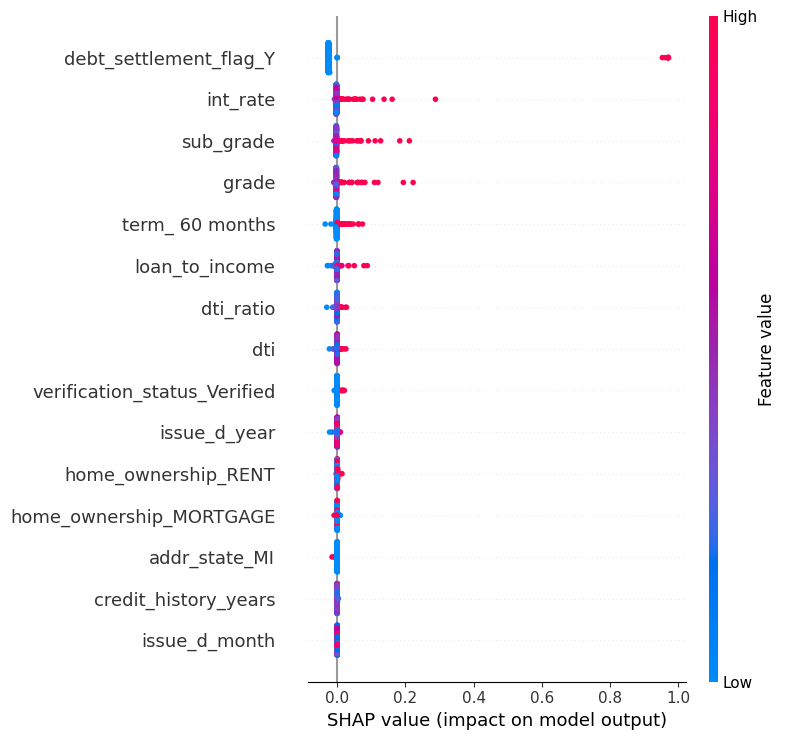

In [ ]:
shap.summary_plot(shap_values, X_sample)
plt.title("SHAP Summary Plot GNB class 1", fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation:**
- `debt_settlement_flag_Y`, `int_rate`, `sub_grade`, and `grade` are the top contributors.
- Since GNB recognizes linear and additive patterns the SHAP values produce smooth and predictable patterns.


##Permutation Feature Importance (gnb)

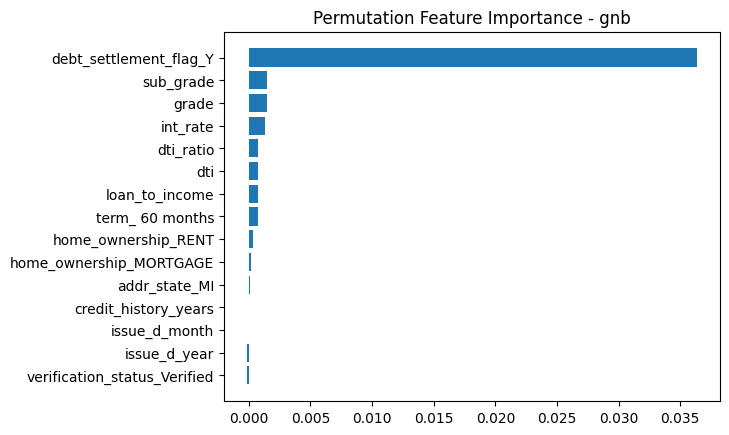

In [ ]:
result = permutation_importance(gnb, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(df.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - gnb")
plt.show()

**Interpretation:**
- Shuffling `debt_settlement_flag_Y` causes the largest drop in performance, proving it’s essential.
- Subgrade, grade, and `int_rate` follow — their removal reduces predictive power, but not signficant.

GNB performs with lower model variance than tree-based models since its probabilistic nature produces weight distributions that spread evenly.

##**Global Surrogate Model:**

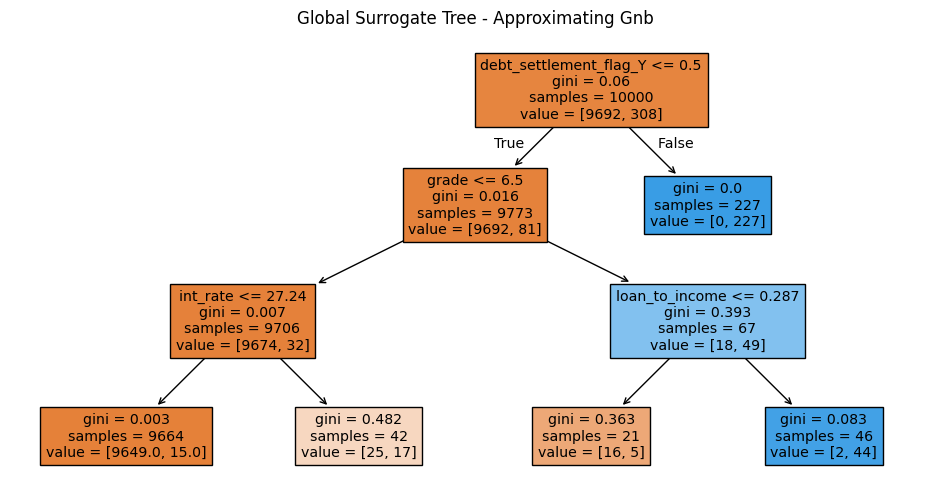

In [ ]:
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_test, y_pred_gnb)

# Plot the surrogate tree
plt.figure(figsize=(12,6))
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating Gnb")
plt.show()

**Interpretation:**
- Starts with `debt_settlement_flag_Y`, then `grade`, `int_rate`, and `loan_to_income`.
- Produces clean if-then rules like:  
  > "If `debt_settlement_flag_Y` = True and `grade` > 6.5 → likely default."

The prediction model functions effectively when displaying results to non-technical business leaders.

##  Partial Dependence Plot (PDP)

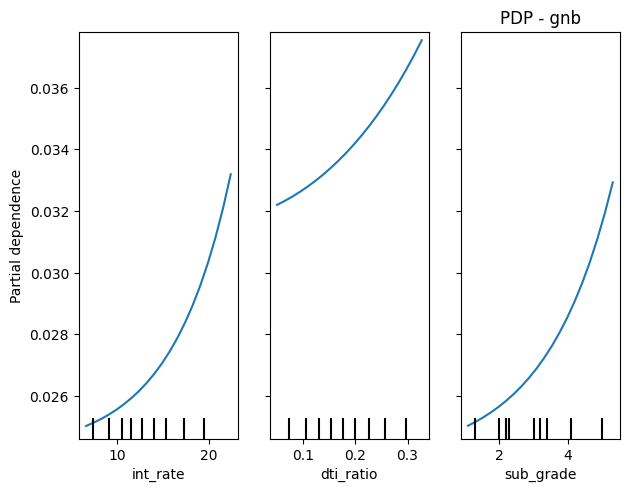

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    gnb,
    X_test,
    features=['int_rate', 'dti_ratio','sub_grade'],
    grid_resolution=20
)
plt.tight_layout()
plt.title("PDP - gnb")
plt.show()

**Interpretation:**
- `int_rate`, `dti_ratio`, and `sub_grade` all show **positive monotonic trends**:  
  As these values increase, the model predicts **higher probability of default**.
- These effects align well with financial intuition and GNB's assumptions of feature independence.

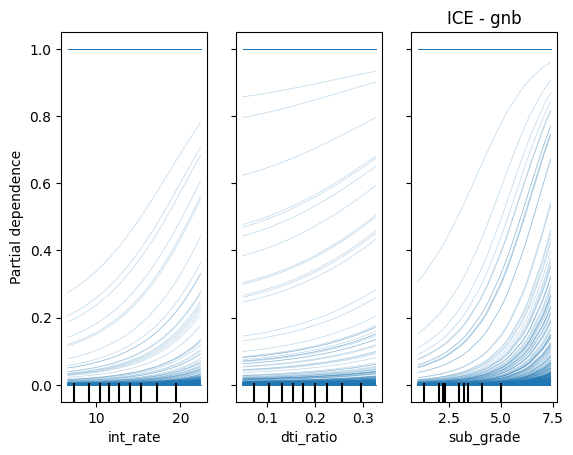

In [ ]:
# ICE is included with PDP in sklearn
PartialDependenceDisplay.from_estimator(gnb, X_test, features=['int_rate', 'dti_ratio','sub_grade'], kind='individual')
plt.title("ICE - gnb")
plt.show()

**Interpretation:**
- Most ICE lines follow the same upward trend — showing GNB’s **uniform linear behavior**.
- Some variability exists in `sub_grade`, suggesting subtle interactions not fully modeled by GNB.
- HGNB demonstrates stability in its performance however it provides limited flexibility when detecting individual characteristics.


In [ ]:
# Split data by class
X_class0 = X_train[y_train == 0]
X_class1 = X_train[y_train == 1]

# Calculate t-test for each feature
z_scores = []
p_values = []

for feature in X_train.columns:
    t_stat, p_val = ttest_ind(X_class0[feature], X_class1[feature], equal_var=False)
    z_scores.append(t_stat)
    p_values.append(p_val)

# Create a DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Z-Score': z_scores,
    'P-Value': p_values
}).sort_values(by="Z-Score", key=abs, ascending=False)

print(feature_importance)

# Identify statistically significant features (p < 0.05)
significant_features = feature_importance[feature_importance["P-Value"] < 0.05]
print("\nSignificant Features:\n", significant_features)

                         Feature    Z-Score        P-Value
12                     sub_grade -52.789106   0.000000e+00
9                          grade -51.579892   0.000000e+00
8                       int_rate -50.886275   0.000000e+00
0                 loan_to_income -27.996894  3.980256e-167
6                      dti_ratio -21.063061   8.910496e-97
1                            dti -21.063061   8.910505e-97
11                  issue_d_year -12.636832   2.120236e-36
14          credit_history_years   4.623995   3.801776e-06
13                 issue_d_month   0.553350   5.800334e-01
3         debt_settlement_flag_Y  -0.380405   7.685882e-01
4                term_ 60 months  -0.303393            NaN
2   verification_status_Verified  -0.108177            NaN
10           home_ownership_RENT  -0.097182            NaN
7        home_ownership_MORTGAGE   0.094026            NaN
5                  addr_state_MI   0.012104            NaN

Significant Features:
                  Feature    Z-Sc

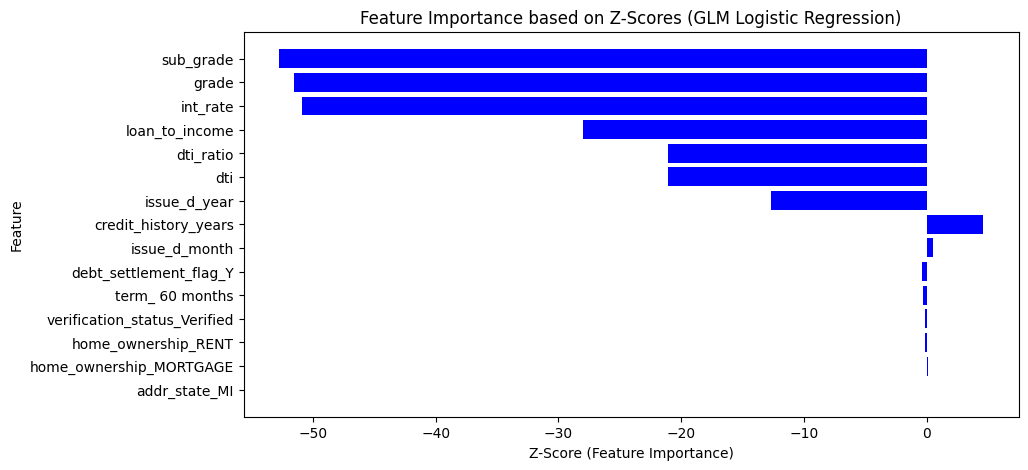

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Z-Score'], color='blue')
plt.xlabel('Z-Score (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance based on Z-Scores (GLM Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

**Interpretation:**
- `sub_grade`, `grade`, and `int_rate` have the strongest separation between defaulters and non-defaulters.
- Z-score explains why these features carry more weight in GNB's prediction formula.
- `debt_settlement_flag_Y` has less Z-score weight, even though SHAP/permutation shows it’s important — because it’s binary and not Gaussian.

 This complements SHAP by showing **why GNB chooses certain features internally**.